# MY NOTEBOOK

## CONFIG

In [90]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [3]:
import os
import fnmatch
import re
import random
import time
import sys
import warnings

import librosa
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import itertools

#import progressbar
from tqdm import tqdm_notebook as tqdm
from time import sleep

from models import *

## Constants

### Local Machine

In [4]:
MTT_DIR = "../MTT/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containing song details (title, artist, id, mp3_path,...)
CLIP_INFO_FINAL = "clip_info_final.csv"
# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"
# CSV : what is it useful for ?
COMPARISONS_FINAL = "comparisons_final.csv"
LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

SUB_DIRS = "0123456789abcdef"

LOGDIR = "checkpoints/"

AUDIO1_path = "../MTT/mtt_data_mp3.zip/0/american_bach_soloists-j_s__bach_\
_transcriptions_of_italian_music-02-concerto_in_a_minor_for_four_harpsichords\
_bwv_1065_ii_largo-88-117.mp3"

### LTS2 Server

This cell defines all the needed data paths, when running on LTS2 server.
Don't run this cell if you are not running the jupyter notebook on the LTS2 server ! (will overwrite the variables defined on the cell above).

You can either create a cell with your own paths, or modify the cell above with your custom paths.

In [ ]:
MTT_DIR = "/mnt/scratch/students/jjgweber-MagnaTagATune/"
DATA_DIRECTORY = MTT_DIR + "dataset/"
WAV_DIRECTORY = MTT_DIR + "wav-dataset/"

# CSV containg the labels (clip_id, labels, mp3_path)
ANNOTATIONS_FINAL = "annotations_final.csv"

LABELS_FILE = MTT_DIR + ANNOTATIONS_FINAL

# need to create this directory on the server !!
LOGDIR = "checkpoints/"

SUB_DIRS = "0123456789abcdef"

### Data

In [5]:
FILE_NB = 25880 #25863
FILE_LENGTH = 465984
# 465984 = 2 × 2 × 2 × 2 × 2 × 2 × 3 × 3 × 809
# useful for batches > for now divide by 9 (instead of 10)

BATCH_NB = 9
BATCH_SIZE = int(FILE_LENGTH/BATCH_NB)
SAMPLE_SIZE = 0
SAMPLE_RATE = 16000
RECEPTIVE_FIELD = 0

TRAIN_DIR = "0123456789abcde"
TEST_DIR ="f"

BASIC_CONFIG ={'numOutputNeurons':500}
LEARNING_RATE = 0.001

### Mutable parameters

In [87]:
# Variables which are often modified to test the algorithm
NB_SONGS = 20
GROUP_SIZE = 20
EPOCHS = 16 # check in paper
LABELS_NAME = ['guitar', 'techno']
NB_LABELS = len(LABELS_NAME)
threshold_tag = 0.7
majority = 9

## Loading tool functions

In [70]:
# later : replace the cell below by this import
from loading import *

## Prediction labels

### Load and clean

In [8]:
start = time.time()
labels = pd.read_csv(LABELS_FILE, sep = '"\t"')
end = time.time()
print("Duration : {:.3}".format(end-start))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Duration : 2.32


In [9]:
# Prepare header to put back in the end
# remove quotes and take all columns except the first one
header = list(map(lambda x : x.replace('"', ''), labels))[1:]
# add back the first column, separated in two
header = ['clip_id', 'no_voice']+header
# create dictionary
header = dict(enumerate(header))

In [10]:
# Solve format problem : two first columns are merged
# extract first column and rest
left, right = labels['"clip_id\t""no voice"'], labels.iloc[:, 1:]
# split first column in two part at separator "\t"
split = left.str.split(pat = "\t", expand=True).replace('"', '')

# put back the first column which is now two, with the rest
cleaned = pd.concat([split, right], axis=1, ignore_index=True) 
# clean by removing quotes and add back header
cleaned = cleaned.apply(lambda col : col.apply(lambda x : x.replace('"', ''))).rename(columns = header)
cleaned.head(5)

,clip_id,no_voice,singer,duet,plucking,hard rock,world,bongos,harpsichord,female singing,...,rap,metal,hip hop,quick,water,baroque,women,fiddle,english,mp3_path
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f/american_bach_soloists-j_s__bach_solo_cantat...


### Analyse the dataset

In [ ]:
## TODO : Some statistics on the MTT dataset ?
nb_labels_per_song = cleaned.iloc[:,1:-1].astype(int).sum(axis=1)
nb_song_per_label = cleaned.iloc[:,1:-1].astype(int).sum(axis=0)
nb_song_per_label = nb_song_per_label.sort_values(ascending=False)

In [ ]:
# label header is the header without clip_id and mp3_path > length 188 instead of 190
label_header = np.asarray(list(header.values()))[1:-1]
label_header_by_freq = np.asarray(nb_song_per_label.index)

In [ ]:
fig = plt.figure(figsize=(16,6))

plot_nb = 70

y_pos = np.arange(plot_nb)
plt.bar(y_pos, nb_song_per_label[:plot_nb], align='center', alpha=0.5)
plt.xticks(y_pos, nb_song_per_label[:plot_nb])
plt.ylabel('Occurence')
plt.title('Label histogram')
plt.xticks(np.arange(plot_nb), label_header_by_freq[:plot_nb], rotation=90, fontsize = 13)

plt.show()

In [ ]:
# Find the most frequent labels to start with for training
most_freq = nb_song_per_label
for i in range(len(nb_song_per_label)) :
    if nb_song_per_label[i] > 2000:
        print(i, "> ", label_header_by_freq[i], " -- ", nb_song_per_label[i])

In [ ]:
best_10_labels = label_header_by_freq[:10]
best_30_labels = label_header_by_freq[:30]

In [ ]:
print("Number of songs : " , cleaned.shape[0])
print("Number of labels : " , cleaned.shape[1]-2) # -2 is for index columns and mp3 path column
print("Max number of songs tagged with the same label : ",max(nb_song_per_label))
print("Max number of labels for a single song : ",max(nb_labels_per_song))

## Co-occurence matrix

Code from : https://stackoverflow.com/questions/20574257/constructing-a-co-occurrence-matrix-in-python-pandas

In [ ]:
from cooccmatrix import *

In [ ]:
chosen_labels = best_10_labels
check_overlaps(chosen_labels, cleaned.loc[:,chosen_labels].values.astype(int))

## Load and format mp3 data 

### Loading audio & tags

In [71]:
# Use Example 
#to add

def load_audio_label(labels, num_songs, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav", randomize_batch=False):
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)
        
    if num_songs > 20 :
        warnings.warn("The argument num_song should not be too high (above 20), make sure this will \
        not cause memory error.", FutureWarning, stacklevel=2)
       
    
    print("Loading data ...")
    start = time.time()
    
    if file_type=="mp3" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir)
    if file_type=="wav" :
        files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
 
    randomized_files = randomize_files(files)
    
    count = 0
    
    audios = np.ndarray(shape=(num_songs * BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs * BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    order = np.zeros(num_songs * BATCH_NB, dtype=int)
    order2 = np.zeros(num_songs * BATCH_NB, dtype=int)
    
    idx = 0
    
    for filename in randomized_files:

        # Load audio (MP3/WAV) file        
        try :
            audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", filename)

        audio = audio.reshape(-1, 1)
         
        for n in range(BATCH_NB) :
            audios[idx] = audio[n*BATCH_SIZE: (n+1)*BATCH_SIZE,:]
            
            # take labels or corresponding song
            
            if file_type=="mp3" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):]]
            
            if file_type=="wav" :
                select_labels  = labels.loc[labels['mp3_path']==filename[len(directory):-4]+".mp3"]

            # select wanted labels
            select_labels = select_labels[labels_name]

            tags[idx] = select_labels.values.reshape(NB_LABELS)
            
            order[idx] = count
            order2[idx] = idx
            idx +=1
        
        count +=1
        if (count % 10) == 0:
            print(count)
    
    if randomize_batch :
        rng_state = np.random.get_state()
        np.random.shuffle(audios)
        np.random.set_state(rng_state)
        np.random.shuffle(tags)
        np.random.set_state(rng_state)
        np.random.shuffle(order)
        np.random.set_state(rng_state)
        np.random.shuffle(order2)
        
    end = time.time()
    duration = end-start
    print(">> Total loading time - {} songs : {:.2f} sec".format(num_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    return audios, tags, order, order2

In [ ]:
def load_audio_label_prim(labels, num_songs, sample_rate=None, directory=WAV_DIRECTORY, \
                     labels_name=LABELS_NAME, sub_dir=None, file_type="wav", randomize_batch=False):
    
    
    assert (file_type=="wav" or file_type=="mp3"), "The argument file_type should be either 'wav', either 'mp3'."
    if (file_type=="wav" and directory!=WAV_DIRECTORY) or (file_type=="mp3" and directory!=DATA_DIRECTORY):
        warnings.warn("File type and directory may not correspond. Make sure the \
        directory gave as parameter contains the right type of files", FutureWarning, stacklevel=2)
        
    if num_songs > 20 :
        warnings.warn("The argument num_song should not be too high (above 20), make sure this will \
        not cause memory error.", FutureWarning, stacklevel=2)
        
    print("Loading data ...")
    start = time.time()
    
    if group_size != None:
        if file_type=="mp3" :
            files = find_files_group(directory, group_size, sample=num_songs, sub_dir=sub_dir, pattern='*.mp3')
        if file_type=="wav" :
            files = find_files_group(directory, group_size, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
    
    else :
        if file_type=="mp3" :
            files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.mp3')
        if file_type=="wav" :
            files = find_files(directory, sample=num_songs, sub_dir=sub_dir, pattern='*.wav')
            
    randomized_files = randomize_files(files)
    
    count = 0
    
    audios = np.ndarray(shape=(num_songs * BATCH_NB, BATCH_SIZE, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(num_songs * BATCH_NB, NB_LABELS), dtype=np.float32, order='F')
    order = np.zeros(num_songs * BATCH_NB, dtype=int)
    order2 = np.zeros(num_songs * BATCH_NB, dtype=int)
    

    
    if group_size != None :
        for group in files :
            load_audio_label_aux(cleaned, group, len(directory), labels_name=labels_name, file_type=file_type)
    
    # check where to put this after        
    if randomize_batch :
        rng_state = np.random.get_state()
        np.random.shuffle(audios)
        np.random.set_state(rng_state)
        np.random.shuffle(tags)
        np.random.set_state(rng_state)
        np.random.shuffle(order)
        np.random.set_state(rng_state)
        np.random.shuffle(order2)
        
    end = time.time()
    duration = end-start
    print(">> Total loading time - {} songs : {:.2f} sec".format(num_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    return audios, tags, order, order2

In [96]:
def load_audio_label_aux(labels, filenames, prefix_len, labels_name=LABELS_NAME, nb_labels=NB_LABELS, \
                         file_type="mp3", batch_size=BATCH_SIZE, nb_batch=BATCH_NB):
    
    nb_songs = len(filenames)
    
    print("Loading {} songs ...".format(nb_songs))
    
    start = time.time()
    
    audios = np.ndarray(shape=(nb_songs * nb_batch, batch_size, 1), dtype=np.float32, order='F')
    tags = np.ndarray(shape=(nb_songs * nb_batch, nb_labels), dtype=np.float32, order='F')

    count = 0

    idx = 0
        
    for f in filenames:

        # Load audio (MP3/WAV) file        
        try :
            audio, _ = librosa.load(f, sr=None, mono=True)
        except EOFError :
            print("EOFERROR : The following file could not be loaded with librosa - ", f)

        audio = audio.reshape(-1, 1)
        
        for n in range(nb_batch) :
            audios[idx] = audio[n*batch_size: (n+1)*batch_size,:]
            
            # take labels or corresponding song
            
            if file_type=="mp3" :
                select_labels  = labels.loc[labels['mp3_path']==f[prefix_len:]]
            
            if file_type=="wav" :
                select_labels  = labels.loc[labels['mp3_path']==f[prefix_len:-4]+".mp3"]

            # select wanted labels
            select_labels = select_labels[labels_name]

            tags[idx] = select_labels.values.reshape(nb_labels)
            
            idx +=1
        
        count +=1
        if (count % 10) == 0:
            print(count)
        
    end = time.time()
    duration = end-start
    
    print(">> Total loading time - {} songs : {:.2f} sec".format(nb_songs, duration))
    print()
    print("Shape of audios list :", audios.shape)
    print("Shape of tags list :", tags.shape)
    
    return audios, tags

In [74]:
# load audios and labels > convert to numpy
# CAREFUL : the argument num_songs is important and shouldn't be too big 
# > otherwise MEMORY ISSUES !!!!!!
audios, tags, order, order2 = load_audio_label(cleaned, num_songs=NB_SONGS, sub_dir=TRAIN_DIR, \
                                file_type="mp3", directory=DATA_DIRECTORY, randomize_batch=True)

Loading data ...
['../MTT/dataset/0/william_brooks-bitter_circus-10-my_love_looks_the_other_way-59-88.mp3', '../MTT/dataset/0/barbara_leoni-human_needs-06-haunted-117-146.mp3', '../MTT/dataset/0/the_bots-truth-02-power_and_domination-59-88.mp3', '../MTT/dataset/0/williamson-a_few_things_to_hear_before_we_all_blow_up-11-whiffle-146-175.mp3', '../MTT/dataset/0/williamson-a_few_things_to_hear_before_we_all_blow_up-04-time_youll_never_get_back-175-204.mp3']
10
20
>> Total loading time - 20 songs : 1.05 sec

Shape of audios list : (180, 51776, 1)
Shape of tags list : (180, 2)


## Neural Network model

### Save neural net state tool

In [ ]:
# not used for now
def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')

In [ ]:
# clean argument passing
def merge_predictions(predictions, order, num_songs = NB_SONGS, threshold=0.5, majority=5):
    print("ORD:",order)
    print(type(predictions[0]))
    #tf.map_fn(tf.invert_permutation, (predictions, order))
    ordered = tf.gather(predictions, indices=order, axis=0)
    
    new_predictions = np.zeros(num_songs * BATCH_NB, dtype= np.float32)
    
    count1 = 0
    for b in range(BATCH_NB) :
        if ordered[b] > threshold :
            count1 +=1
            
    if count1 >= majority :
        for b in range(BATCH_NB) :
            new_predictions[b] = 1
    
    return tf.convert_to_tensor(new_predictions, np.float32)

### Initialize tf

In [36]:
# run this cell everytime before relaunching tensorflow session
tf.reset_default_graph()

### Training

In [40]:
# keep results for plotting
train_loss_results = []
train_auc_results = []

In [65]:
# Lines used to understand local vs global vs trainable
'''print("GLOBAL :", [str(i.name) for i in tf.global_variables()])
    print("LOCAL :", [str(i.name) for i in tf.local_variables()])
    print("TRAINABLE :",[str(i.name) for i in tf.trainable_variables()]) '''

'print("GLOBAL :", [str(i.name) for i in tf.global_variables()])\n    print("LOCAL :", [str(i.name) for i in tf.local_variables()])\n    print("TRAINABLE :",[str(i.name) for i in tf.trainable_variables()]) '

In [42]:
print("Initializing tf model ...")

audio_tf= tf.convert_to_tensor(audios, np.float32)
print("Input shape : {}".format(audio_tf.shape))
print("Labels : {}".format(tags.flatten()))
print()

net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
#predictions = merge_predictions(predictions, order2)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags, predictions=predictions)


# Saver for storing checkpoints of the model. (Wavenets)
saver = tf.train.Saver(var_list=tf.global_variables())
    
print("Start training...")

start = time.time()

with tf.Session() as sess:
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    sess.run(init)
    
    for epoch in tqdm(range(EPOCHS)):
        t0_epoch = time.time()
        predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc])
        #print(type(predict))
        auc_result, update_op = auc_score
        
        train_loss_results.append(loss_value)
        train_auc_results.append(auc_result)
        
        t1_epoch = time.time()
        dur = t1_epoch-t0_epoch
        print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}".format(epoch,\
                                                                                    dur, loss_value, auc_result))
        #print("Predictions : {}".format(predict.flatten()))
        #print()
     
    # use wavenet function > see later (for now simplest way)
    #save(saver, sess, LOGDIR, EPOCHS)
    saver.save(sess, LOGDIR)

end = time.time()
duration2 = end-start
print("Total time: {:.2f} sec.".format(duration2))

Initializing tf model ...
Input shape : (180, 51776, 1)
Labels : [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1

Iter:   0, Time (in sec): 24.80, Loss: 0.9404, AUC : 0.0000
Iter:   1, Time (in sec): 16.95, Loss: 0.8653, AUC : 0.2589
Iter:   2, Time (in sec): 16.33, Loss: 0.8232, AUC : 0.6345
Iter:   3, Time (in sec): 17.32, Loss: 0.7796, AUC : 0.7534
Iter:   4, Time (in sec): 16.22, Loss: 0.7426, AUC : 0.8180
Iter:   5, Time (in sec): 16.08, Loss: 0.7159, AUC : 0.8687
Iter:   6, Time (in sec): 16.61, Loss: 0.6959, AUC : 0.9032
Iter:   7, Time (in sec): 17.03, Loss: 0.6828, AUC : 0.9264
Iter:   8, Time (in sec): 16.72, Loss: 0.6720, AUC : 0.9424
Iter:   9, Time (in sec): 22.52, Loss: 0.6641, AUC : 0.9540
Iter:  10, Time (in sec): 17.91, Loss: 0.6560, AUC : 0.9626
Iter:  11, Time (in sec): 16.89, Loss: 0.6532, AUC : 0.9690
Iter:  12, Time (in sec): 16.94, Loss: 0.6487, AUC : 0.9738
Iter:  13, Time (in sec): 18.18, Loss: 0.6457, AUC : 0.9777
Iter:  14, Time (in sec): 16.90, Loss: 0.6442, AUC : 0.9808
Iter:  15, Time (in sec): 17.20, Loss: 0.6421, AUC : 0.9832

Total time: 287.56 sec.


In [99]:
files_by_group = find_files_group(DATA_DIRECTORY, GROUP_SIZE,sample =  pattern='*.mp3', sub_dir=TRAIN_DIR)

#for g in files_by_group :
g = files_by_group[10]

audios, tags = load_audio_label_aux(cleaned, g, len(DATA_DIRECTORY), labels_name=LABELS_NAME, \
                    nb_labels=NB_LABELS, file_type="mp3", batch_size=BATCH_SIZE, nb_batch=BATCH_NB)

Loading 20 songs ...
10
20
>> Total loading time - 20 songs : 0.93 sec

Shape of audios list : (180, 51776, 1)
Shape of tags list : (180, 2)


In [88]:
# VERSION 2 : feed group by group
files_by_group = find_files_group(DATA_DIRECTORY, GROUP_SIZE, pattern='*.mp3', sub_dir=TRAIN_DIR)

with tf.Session() as sess:
    # Go through the whole DS at each EPOCH
    for epoch in tqdm(range(EPOCHS)):

        for subdir in TRAIN_DIR :
            audios, tags, order, order2 = load_audio_label(cleaned, num_songs = GROUP_SIZE, sub_dir=subdir, \
                                        file_type="mp3", directory=DATA_DIRECTORY, randomize_batch=True)
            
            audio_tf= tf.convert_to_tensor(audios, np.float32)


print("Initializing tf model ...")

audio_tf= tf.convert_to_tensor(audios, np.float32)
print("Input shape : {}".format(audio_tf.shape))
print("Labels : {}".format(tags.flatten()))
print()

net = build_model(audio_tf, is_training=True, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
#predictions = merge_predictions(predictions, order2)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags, predictions=predictions)


# Saver for storing checkpoints of the model. (Wavenets)
saver = tf.train.Saver(var_list=tf.global_variables())
    
print("Start training...")

start = time.time()

with tf.Session() as sess:
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    
    sess.run(init)
    

        t0_epoch = time.time()
        predict, _, loss_value, auc_score = sess.run([predictions, train_op, reduced_loss, auc])
        #print(type(predict))
        auc_result, update_op = auc_score
        
        train_loss_results.append(loss_value)
        train_auc_results.append(auc_result)
        
        t1_epoch = time.time()
        dur = t1_epoch-t0_epoch
        print("Iter: {:3}, Time (in sec): {:.2f}, Loss: {:.4f}, AUC : {:.4f}".format(epoch,\
                                                                                    dur, loss_value, auc_result))
        #print("Predictions : {}".format(predict.flatten()))
        #print()
     
    # use wavenet function > see later (for now simplest way)
    #save(saver, sess, LOGDIR, EPOCHS)
    saver.save(sess, LOGDIR)

end = time.time()
duration2 = end-start
print("Total time: {:.2f} sec.".format(duration2))

IndentationError: unexpected indent (<ipython-input-88-8453d738c045>, line 44)

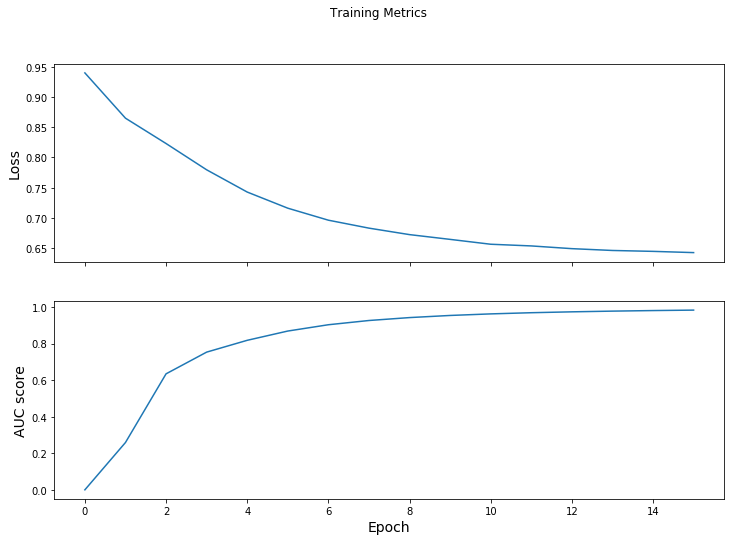

In [43]:
# modify this : the epoch axis not not integers which doesn't make sense
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("AUC score", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_auc_results)
plt.show()

## Test set

In [54]:
tf.reset_default_graph()

In [45]:
TEST_SIZE = 10

audios_test, tags_test, order_test, order_test2 = load_audio_label(cleaned, num_songs=TEST_SIZE, sub_dir=TEST_DIR)

audios_test_tf = tf.convert_to_tensor(audios_test, np.float32)

In [55]:
net = build_model(audio_tf, is_training=False, config=BASIC_CONFIG) 
predictions = tf.layers.dense(net, NB_LABELS, activation=tf.sigmoid)
#predictions = merge_predictions(predictions, order2)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tags, logits = predictions)
reduced_loss = tf.reduce_mean(loss)
train_op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(reduced_loss)
auc = tf.metrics.auc(labels = tags, predictions=predictions)

ValueError: Tensor("conv1d/kernel:0", shape=(3, 1, 64), dtype=float32_ref) must be from the same graph as Tensor("Const:0", shape=(180, 51776, 1), dtype=float32).

In [47]:
variables_to_restore = {
    var.name[:-2]: var for var in tf.global_variables()
    if not ('state_buffer' in var.name or 'pointer' in var.name)}

# Add ops to save and restore all the variables.
saver = tf.train.Saver(variables_to_restore)

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
      # Restore variables from disk.
    saver.restore(sess, LOGDIR)
    print("Model restored.")
    
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

    sess.run(init) 

    predicts = sess.run([audios_test_tf, predictions, train_op, reduced_loss, auc])

INFO:tensorflow:Restoring parameters from checkpoints/
Model restored.


In [48]:
# Print some results 
print("AUC Score :", predicts[4])

AUC Score : (0.0, 1.0)


In [49]:
print("PREDICTIONS :", predicts[1])
print("TRUE :", tags_test)

PREDICTIONS : [[0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.60562223 0.5653917 ]
 [0.6056222

Following TF tutorial for custom training
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb